In [1]:
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import f1_score
from itertools import cycle, islice
from operator import itemgetter
import sif_embedding_wrapper
import pandas as pd
import numpy as np
import itertools
import codecs
import utils
import os

In [2]:
from gensim.test.utils import common_texts
from gensim.models import Word2Vec

model = Word2Vec(common_texts, size=100, window=5, min_count=1, workers=4)
word_vectors = model.wv

In [16]:
word_vectors.most_similar('interface')

[('computer', 0.13591855764389038),
 ('survey', 0.06877830624580383),
 ('system', -0.02093014121055603),
 ('graph', -0.0476025827229023),
 ('user', -0.054847896099090576),
 ('time', -0.07450541108846664),
 ('response', -0.10239669680595398),
 ('trees', -0.1367427408695221),
 ('eps', -0.13927116990089417),
 ('minors', -0.15551555156707764)]

<IPython.core.display.Javascript object>


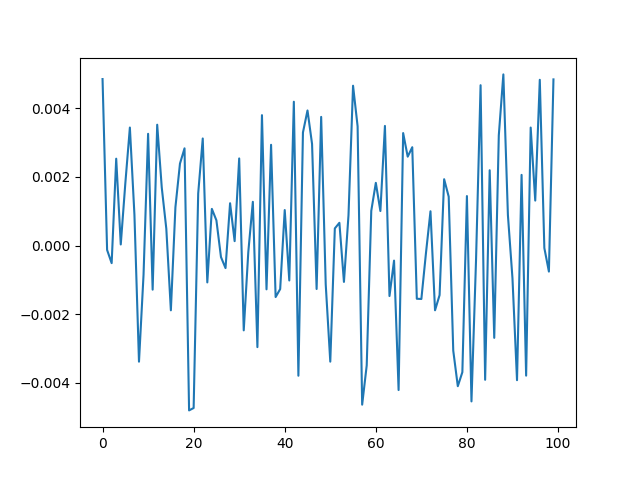

In [24]:
%matplotlib notebook
import matplotlib.pyplot as plt  

plt.plot(word_vectors['interface'])

    
    


In [2]:
from gensim.models.keyedvectors import KeyedVectors

# model = KeyedVectors.load_word2vec_format('/home/stirunag/pre-trained_word_embeddings/PubMed-and-PMC-w2v.bin', binary=True)
# model.save_word2vec_format('/home/stirunag/pre-trained_word_embeddings/PubMed-and-PMC-w2v.txt', binary=False)

# sed -i -n -e '2,$p'file.txt to remove first line from the txt file


words, embs, weight4ind = sif_embedding_wrapper.load_embeddings("/home/stirunag/pre-trained_word_embeddings/PubMed-w2v.txt", 
                                                     '/home/stirunag/pre-trained_word_embeddings/wiki/enwiki_vocab_min200.txt')


# words, embs, weight4ind = sif_embedding_wrapper.load_embeddings("/home/stirunag/pre-trained_word_embeddings/PubMed-and-PMC-FS.txt", 
#                                                      '/home/stirunag/pre-trained_word_embeddings/wiki/enwiki_vocab_min200.txt')

# words, embs, weight4ind = sif_embedding_wrapper.load_embeddings("/home/stirunag/pre-trained_word_embeddings/glove/glove.6B.300d.txt", 
#                                                       '/home/stirunag/pre-trained_word_embeddings/wiki/enwiki_vocab_min200.txt')

In [3]:
# get the current working directory
data_path = os.path.abspath(os.path.join(os.path.dirname( '__file__' ), '..', 'Datasets'))+'/'

# Although the dataset says csv, it is tab delimited. In addition to this, they have severe codels problems. 
# So best to parse throught codes first. 
# UnicodeDecodeError: 'utf-8' codec can't decode byte 0xfc in position 2: invalid start byte

#open for reading with "universal" type set

doc_d_t = codecs.open(data_path+'EUADR_Corpus_IBIgroup/'+'EUADR_drug_target'+'.csv','rU','UTF-8') 
EUADR_drug_target = pd.read_csv(doc_d_t, sep='\t', na_filter = False)
EUADR_drug_target['CLASS'] = 'drug_gene'

doc_t_d = codecs.open(data_path+'EUADR_Corpus_IBIgroup/'+'EUADR_target_disease'+'.csv','rU','UTF-8',errors='ignore') 
EUADR_target_disease = pd.read_csv(doc_t_d, sep='\t', na_filter = False)
EUADR_target_disease['CLASS'] = 'gene_disease'
       
doc_d_d = codecs.open(data_path+'EUADR_Corpus_IBIgroup/'+'EUADR_drug_disease'+'.csv','rU','UTF-8')                       
EUADR_drug_disease = pd.read_csv(doc_d_d, sep='\t', na_filter = False)
EUADR_drug_disease['CLASS'] = 'drug_disease'



In [4]:
df = EUADR_drug_target.append(EUADR_target_disease).append(EUADR_drug_disease)
df.reset_index(inplace=True)

doc_embeddings = sif_embedding_wrapper.sentences2vecs(df["SENTENCE"], embs, words, weight4ind)
df["vector"] = pd.Series(list(doc_embeddings))

In [5]:
ground_truth = {}

for idx, row in df.iterrows():
    ground_truth[idx] = row['CLASS']

categories = list(df["CLASS"].unique())
categories    

['drug_gene', 'gene_disease', 'drug_disease']

In [6]:
# Use LDA to get the topics and assign to class to find top performaning sentences

min_text_length=80
max_iter=150
batch_size=512
learning_offset=300.
n_topics = len(categories)


docs = df

unclassifiable = list(docs[docs["SENTENCE"].map(len) < min_text_length].index)
filtered = docs[~docs.index.isin(unclassifiable)]
ids = [d for d in list(filtered.index)[0:10]]

n_features = 50000
tf_vectorizer = TfidfVectorizer(
    stop_words='english',
    max_df=0.95,
    min_df=0.1,
    max_features=n_features)
tf = tf_vectorizer.fit_transform(list(filtered.loc[:, 'SENTENCE']))

lda = LatentDirichletAllocation(
    n_components=n_topics,
    max_iter=max_iter,
    batch_size=batch_size,
    learning_method='online',
    learning_offset=learning_offset,
    random_state=0)

lda.fit(tf)
doc_topics = lda.transform(tf)

In [7]:
topic_leaders = {"topic_{}".format(i): [] for i in iter(range(n_topics))}
doc_id = filtered.index

for idx, probs in enumerate(doc_topics):
    score = max(probs)
    topic = np.argmax(probs)
    doc_id = filtered.index[idx]
    topic_leaders["topic_{}".format(topic)].append({"doc_id": doc_id, "score": score})

for i in iter(range(n_topics)):
    topic_leaders["topic_{}".format(i)] = sorted(
        topic_leaders["topic_{}".format(i)], key=itemgetter('score'), reverse=True)
        
    

# topic_leaders

In [8]:
# select only those sentences which have score more than 65%

sentences = {c:[] for c in categories} 
selected_sentences = {c:[] for c in categories}
sentences_with_score = {c:[] for c in categories}


for each_topic in topic_leaders:
    for each_doc in topic_leaders[each_topic]:
        gt = ground_truth[each_doc['doc_id']]
        sentences[gt].append(each_doc['doc_id'])
        sentences_with_score[gt].append(each_doc['score'])
#         print(each_doc['score'])
        if each_doc['score']>0.66:
             selected_sentences[gt].append(each_doc['doc_id'])
    
# selected_sentences

In [9]:
# Get average/mean of the sentence vectors that represent our topics 
category_vecs = {}
for c in categories:
    vectors = np.asarray(list(df.loc[df.index.isin(selected_sentences[c])].vector))
    category_vecs[c] = np.mean(vectors, axis=0)

    
category_vecs    

{'drug_disease': array([ -5.01743151e-02,  -1.09790344e-02,   1.32235805e-02,
          4.57500888e-02,  -6.02813680e-02,  -1.12274456e-01,
         -8.05164539e-02,  -3.91805726e-02,   5.68890392e-02,
          6.75453327e-04,  -6.64619047e-03,   2.89823900e-02,
         -5.54063128e-02,   1.35439396e-02,   7.87501140e-02,
         -6.22668875e-02,  -2.20562307e-03,   1.01923985e-01,
          8.25286633e-02,  -7.53912769e-02,   1.19532155e-01,
         -7.29718227e-03,   1.03288603e-02,   8.98741346e-03,
         -4.44455240e-02,  -6.73095505e-02,   3.60859984e-02,
         -1.35875118e-03,  -1.80442843e-02,   6.14259915e-02,
         -9.17281030e-02,   2.98729526e-02,  -1.39525150e-01,
         -1.80716440e-02,   5.69690641e-02,  -2.13739669e-02,
          3.84281359e-03,  -2.95823026e-02,   5.30749657e-02,
         -1.02126391e-01,  -1.14117626e-01,  -5.48280409e-03,
          2.94137054e-02,  -2.52531384e-03,   2.39741648e-02,
         -3.23843350e-02,   3.56907206e-03,   2.163987

In [10]:
# Try to predict the label of unknown sentences

predictions = {}

selected_idx = [j for i in selected_sentences.values() for j in i]

for idx, row in df.iterrows():
    if idx in selected_idx:
        max_sim = 0
        winner = 'Unknown'
        for j in category_vecs:
            sim = cosine_similarity(row["vector"].reshape(1, -1), category_vecs[j].reshape(1, -1)).flatten()[0]
            if sim > max_sim:
                max_sim = sim
                winner = j
        predictions[idx] = winner
    

In [11]:
def get_accuracy_score(predictions, truth_dict):
    preds = []
    labels = []
    mis_classified = []
    mis_pred = []
    
    for k,v in predictions.items():
        preds.append(v)
        labels.append(truth_dict[k])
        if v!=truth_dict[k]:
#             print(str(v) + '--x--' + str(truth_dict[k]))
            mis_pred.append(str(v))
            mis_classified.append(k)

    return f1_score(labels, preds, average='weighted'), mis_classified, mis_pred


score, miss_classified_df, miss_pred = get_accuracy_score(predictions, ground_truth)
score

0.86787541612152574

In [12]:
pd.set_option('display.max_colwidth', -1)

miss_calssified_df = df.iloc[miss_classified_df , [12,13]] 
miss_calssified_df['Predicted-CLASS'] = miss_pred
# miss_calssified_df

result_path = os.path.abspath(os.path.join(os.path.dirname( '__file__' ), '..', 'Results'))+'/'
miss_calssified_df.to_csv(result_path+'miss_predictions_train.csv')

In [14]:
# Generalisation on the Unseen Dataset GAD


doc_t_d = codecs.open(data_path+'GAD_Corpus_IBIgroup/'+'GAD_Y_N'+'.csv','rU','UTF-8',errors='ignore') 
GAD_target_disease = pd.read_csv(doc_t_d, sep='\t', na_filter = False)
GAD_target_disease['CLASS'] = 'gene_disease'


# GAD_target_disease.head(10)
doc_embeddings = sif_embedding_wrapper.sentences2vecs(GAD_target_disease["GAD_CONCLUSION"], embs, words, weight4ind)
GAD_target_disease["vector"] = pd.Series(list(doc_embeddings))

In [15]:
GAD_test_ground_truth = {}

for idx, row in GAD_target_disease.iterrows():
    GAD_test_ground_truth[idx] = row['CLASS']
    
# Try to predict the label of unknown sentences

GAD_test_predictions = {}

for idx, row in GAD_target_disease.iterrows():
    max_sim = 0.60
    winner = 'unknown'
    for j in category_vecs:
        sim = cosine_similarity(row["vector"].reshape(1, -1), category_vecs[j].reshape(1, -1)).flatten()[0]
        if sim > max_sim:
            max_sim = sim
            winner = j
    GAD_test_predictions[idx] = winner   
    
    
GAD_score, GAD_miss_classified, GAD_miss_pred = get_accuracy_score(GAD_test_predictions, GAD_test_ground_truth)
GAD_score    

/home/synoptica/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


0.88071928071928085

In [17]:
miss_calssified_GAD_test = GAD_target_disease.iloc[GAD_miss_classified , [10,11]] 
miss_calssified_GAD_test['Predicted-CLASS'] = GAD_miss_pred
# miss_calssified_df_test
miss_calssified_GAD_test.to_csv(result_path+'miss_predictions_test.csv')

In [18]:
# Test new sentence

# test_sample = 'This study assessed associations between the CYP4F2 gene and myocardial infarction (MI), using a haplotype-based case-control study of 234 MI patients and 248 controls genotyped for 5 single-nucleotide polymorphisms (rs3093105, rs3093135, rs1558139, rs2108622, rs3093200).'
# test_sample = 'Assessment of 1177 human immunodeficiency virus (HIV) resistance genotypes at an HIV/AIDS clinic showed a decrease in the incidence of the K65R mutation, from 15.2% of isolates during the period 2002-2004 to 2.7% of isolates during the period 2005-2006 (P < .001), despite elevated and stable rates of tenofovir use.'
# test_sample = 'Doxorubicin-induced DNA damage was also specifically abolished by the proteasome inhibitors bortezomib and MG132 and much reduced in top2beta(-/-) mouse embryonic fibroblasts (MEF) compared with TOP2beta(+/+) MEFs, suggesting the involvement of proteasome and DNA topoisomerase IIbeta (Top2beta).'
# test_sample = 'SLC9A6 at Xq26.3 (Gilfillan et al., 2008)X-linked mental retardation'
test_sample = 'DLBCL was identified by a microenvironment gene expression signature and is associated with increased expression of inflammatory mediators, such as multiple components of the T-cell receptor (TCR), molecules associated with T/NK-cell activation and the complement cascade, downstream targets of IFNγ'

test_embedding = sif_embedding_wrapper.sentences2vecs([test_sample], embs, words, weight4ind)

sim = {}
for j in category_vecs:
    sim[j] = cosine_similarity(test_embedding.reshape(1, -1), category_vecs[j].reshape(1, -1)).flatten()[0]

sim    
    

{'drug_disease': 0.24992276297691893,
 'drug_gene': 0.72044882673548982,
 'gene_disease': 0.65276057566855705}

In [19]:
# Testing on the 30 papers dataset


import json

with open(data_path+'EBI Standard/'+'rel_data_bronze.json') as json_file:
    data = json.load(json_file)

EBI_standard = []

for each_point in data:
    for each_sent in data[each_point]:
        EBI_standard.append({'SENTENCE': each_sent['sent'], 'CLASS': each_sent['rel']})    
        
EBI_standard_temp = pd.DataFrame(EBI_standard)   

EBI_standard_temp['CLASS'] = EBI_standard_temp['CLASS'].apply(lambda x: x.replace('YGD', 'gene_disease').replace('NGD', 'other').replace('AMB', 'other'))
EBI_standard_temp.to_csv(data_path+'EBI_bronze_standard.csv')

In [20]:
doc_embeddings = sif_embedding_wrapper.sentences2vecs(EBI_standard_temp["SENTENCE"], embs, words, weight4ind)
EBI_standard_temp["vector"] = pd.Series(list(doc_embeddings))


EBI_test_ground_truth = {}

for idx, row in EBI_standard_temp.iterrows():
    EBI_test_ground_truth[idx] = row['CLASS']
    
# Try to predict the label of unknown sentences

EBI_test_predictions = {}

for idx, row in EBI_standard_temp.iterrows():
    max_sim = 0.30
    winner = 'other'
    for j in category_vecs:
        sim = cosine_similarity(row["vector"].reshape(1, -1), category_vecs[j].reshape(1, -1)).flatten()[0]
        if sim > max_sim:
            max_sim = sim
            winner = j
    EBI_test_predictions[idx] = winner    
    

EBI_score, EBI_miss_classified, EBI_miss_pred = get_accuracy_score(EBI_test_predictions, EBI_test_ground_truth)
EBI_score    

/home/synoptica/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


0.50367132867132858

In [21]:
miss_calssified_EBI_test = EBI_standard_temp.iloc[EBI_miss_classified , [0,1]] 
miss_calssified_EBI_test['Predicted-CLASS'] = EBI_miss_pred
miss_calssified_EBI_test

,CLASS,SENTENCE,Predicted-CLASS
1,other,"SLT can cause oral cancer [4], [5] and nicotine addiction [6] and is associated with several other health conditions including oral pain [7], cardiovascular diseases [8], hypertension [9], diabetes [10], loss in bone density [11], and problems during pregnancy and following childbirth [12].",drug_disease
3,other,This increased likelihood of SLT use is related to the social acceptance of SLT use by the older people and a greater appeal of cigarette among the younger generations who may be taking up smoking instead of SLT use.,gene_disease
4,other,"Use of SLT may provide a supplementation or substitution of nicotine intake for cigarette smokers [31] encouraging their continued use; this scenario could be particularly true in situations in which smoking is not socially acceptable, but SLT use is.",drug_disease
6,other,"Interleukin (IL)-1β, IL-4, IL-6, IL-10, IL-12, IL-13, IL-17, interferon (IFN)-γ, chemokine C-C motif ligand 5 (CCL5) and tumor necrosis factor (TNF)-α were tested in tear samples and sera of keratoconus and control individuals by multiplex immuno-bead assays.",gene_disease
8,gene_disease,"The decreases in IL-12, TNF-α and CCL5 were statistically significant, while the IL-13 decrease was statistically significant in the severe keratoconus group only.",drug_disease
20,gene_disease,"Of the TH2-related cytokines, the decrease in IL-13 was statistically significant in severe keratoconus versus control subjects.",drug_disease
25,gene_disease,"Based on these limited data (Figure 3), there was a trend towards increased IL-17 (72.5±59.2 pg/ml) in keratoconus tear fluids compared to control samples (18.5±7.8 pg/ml).",drug_disease
26,gene_disease,"The decrease in IL-4 in the keratoconus pool (7.6±5 pg/ml), compared to controls (14.2±8.6 pg/ml) was statistically significant (p≤0.05, Mann-Whitney test).",drug_disease
27,gene_disease,"The increase in IL-17 in keratoconus samples (72.5±59.2 pg/ml) compared to controls (18.5±7.8 pg/ml), was statistically significant (p≤0.05, Mann-Whitney test).",drug_disease
29,gene_disease,"Comparing tear fluid cytokines in the control and keratoconus subjects, we noted an increase in IL-6 in keratoconus, in agreement with earlier reports [8], [13].",drug_disease


In [22]:
# Get PolySearch dataset
ColNames = ['entity_1', 'entity_2', 'Association', 'PMID','Sentence']

Poly_doc_d_t = codecs.open(data_path+'PolySearch/'+'p1_disease_gene_testset.simple'+'.tsv','rU','UTF-8') 
Poly_target_disease = pd.read_csv(Poly_doc_d_t, sep='\t', na_filter = False, names = ColNames)
Poly_target_disease['CLASS'] = 'gene_disease'

doc_embeddings = sif_embedding_wrapper.sentences2vecs(Poly_target_disease["Sentence"], embs, words, weight4ind)
Poly_target_disease["vector"] = pd.Series(list(doc_embeddings))

In [23]:
Poly_test_ground_truth = {}

for idx, row in Poly_target_disease.iterrows():
    Poly_test_ground_truth[idx] = row['CLASS']
    
# Try to predict the label of unknown sentences

Poly_test_predictions = {}

for idx, row in Poly_target_disease.iterrows():
    max_sim = 0.30
    winner = 'unknown'
    for j in category_vecs:
        sim = cosine_similarity(row["vector"].reshape(1, -1), category_vecs[j].reshape(1, -1)).flatten()[0]
        if sim > max_sim:
            max_sim = sim
            winner = j
    Poly_test_predictions[idx] = winner   

In [62]:
# def get_accuracy_score(predictions, truth_dict):
#     preds = []
#     labels = []
#     mis_classified = []
#     mis_pred = []
    
#     for k,v in predictions.items():
#         preds.append(v)
#         labels.append(truth_dict[k])
#         if v!=truth_dict[k]:
# #             print(str(v) + '--x--' + str(truth_dict[k]))
#             mis_classified.append(k)
#             mis_pred.append(str(v))

#     return f1_score(labels, preds, average='weighted'), mis_classified, mis_pred


# score, miss_classified, miss_pred = get_accuracy_score(test_predictions, test_ground_truth)
# score    
# test_predictions

/home/synoptica/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


0.84768211920529801

In [25]:
miss_calssified_Poly_test = Poly_target_disease.loc[Poly_miss_classified,['Sentence', 'CLASS']]
miss_calssified_Poly_test['Predicted-CLASS'] = Poly_miss_pred
miss_calssified_Poly_test

,Sentence,CLASS,Predicted-CLASS
1,"Suwannarat P, O'Brien K, Perry MB, Sebring N, Bernardini I, Kaiser-Kupfer MI, Rubin BI, Tsilou E, Gerber LH, Gahl WA: Use of nitisinone in patients with alkaptonuria. Metabolism. 2005 Jun;54(6):719-28. Alkaptonuria, a rare autosomal recessive disorder caused by mutations in the HGD gene and deficiency of homogentisate 1,2 dioxygenase, is characterized by ochronosis, arthritis, and daily excretion of gram quantities of homogentisic acid (HGA). Nitisinone, an inhibitor of the enzyme 4-hydroxyphenylpyruvate dioxygenase, can drastically reduce urinary excretion of HGA in individuals with alkaptonuria. We investigated the safety and the HGA-depleting efficacy of nitisinone in an open-label, single-center study of 9 alkaptonuria patients (5 women, 4 men; 35-69 years of age) over the course of 3 to 4 months. Each patient received nitisinone in incremental doses, 0.35 mg bid followed by 1.05 mg bid, and remained on this dosage and a regular diet for 3 months. Nitisinone reduced urinary HGA levels from an average of 4.0 +/- 1.8 (SD) g/day to 0.2 +/- 0.2 g/day ( P tyrosine concentration, initially 68 +/- 18 mmicro mol/L, rose to 760 +/- 181 micro mol/L ( P protein-restricted diet (40 g/day), and their mean plasma tyrosine level fell from 755 +/- 167 to 603 +/- 114 mu mol/L. Six of the 7 patients who received nitisinone for more than 1 week reported decreased pain in their affected joints. Weekly ophthalmologic examinations showed no signs of corneal toxicity. Adverse events included the passing of kidney stones, the recognition of symptoms related to aortic stenosis, and elevation of liver transaminase levels. We conclude that low-dose nitisinone effectively reduced urinary HGA levels in patients with alkaptonuria. Future long-term clinical trials are planned to determine the benefits of nitisinone in preventing joint deterioration and providing pain relief, and its long-term side effects.",gene_disease,drug_disease
3,"Forslind K, Wollheim FA, Akesson B, Rydholm U: Alkaptonuria and ochronosis in three siblings. Clin Exp Rheumatol. 1988 Jul-Sep;6(3):289-92. Ascorbic acid treatment monitored by urinary HGA excretion. Patients with alkaptonuria lack homogentisate 1,2-dioxygenase leading to retention of homogentistic acid (HGA) in body fluids and eventually to tissue deposition of oxidation products, giving rise to the clinical picture of ochronosis. Ascorbic acid is a known inhibitor of the enzyme which catalyses the oxidation of homogentisic acid (HGA) to the polymer with affinity for collagen and was used in the treatment of three siblings with alkaptonuria. Ascorbic acid 500 mg bid was administered for 12 months. Two of the siblings tolerated the treatment, and in one the symptoms improved, whereas in the other they worsened. Plasma and urinary levels of HGA were monitored with a new HPLC method. Ascorbic acid is not effective in the treatment of symptomatic ochronosis.",gene_disease,drug_disease
5,"Zhou H, Monack DM, Kayagaki N, Wertz I, Yin J, Wolf B, Dixit VM: Yersinia virulence factor YopJ acts as a deubiquitinase to inhibit NF-kappa B activation. J Exp Med. 2005 Nov 21;202(10):1327-32. The bacterial pathogens of the genus Yersinia, the causative agents of plague, septicemia, and gastrointestinal syndromes, use a type III secretion system to inject virulence factors into host target cells. One virulence factor, YopJ, is essential for the death of infected macrophages and can block host proinflammatory responses by inhibiting both the nuclear factor kappaB (NF-kappaB) and mitogen-activated protein kinase pathways, which might be important for evasion of the host immune response and aid in establishing a systemic infection. Here, we show that YopJ is a promiscuous deubiquitinating enzyme that negatively regulates signaling by removing ubiquitin moieties from critical proteins, such as TRAF2, TRAF6, and IkappaBalpha. In contrast to the cylindromatosis tumor suppressor CYLD, which attenuates NF-kappaB 